### main_pretrain

In [257]:
from main_pretrains.main_pretrain import main_pretrain, set_seed
from models.transformer import TransformerSOH
from data_provider import data_provider
import torch
import torch.optim as optim
import random
import numpy as np

source_set_train, source_loader_train = data_provider(name = 'GOTION', shuffle_flag=True, batch_size=10, flag = 'train')
source_set_test, source_loader_test = data_provider(name = 'GOTION', shuffle_flag=False, batch_size=10, flag = 'test')

# model parameters
input_dim = 1
embed_dim = 128
num_heads = 4
num_layers = 2

# training parameters
mask_ratrio = 0.3
num_epochs = 10
LR = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
f_g = TransformerSOH(input_dim, embed_dim, num_heads, num_layers, PPA= True).to(device)
optimizer = optim.AdamW(f_g.parameters(), lr=LR)
set_seed(0)
main_pretrain(train_loader= source_loader_train, test_loader= source_loader_test, model=f_g, optimizer=optimizer, device=device,mask_ratio=mask_ratrio, num_epochs=num_epochs)
torch.save(f_g.state_dict(), 'saved_models/transformer/f_g.pt')

GOTION train 2840
GOTION test 1419
cuda
Epoch [1/10], Reconstruction (train) Loss: 0.018935939433581104, Reconstruction (test) Loss: 0.00230451769926782
Epoch [2/10], Reconstruction (train) Loss: 0.001771644638313479, Reconstruction (test) Loss: 0.001441218866474769
Epoch [3/10], Reconstruction (train) Loss: 0.0013606054671469446, Reconstruction (test) Loss: 0.0010844574705041734
Epoch [4/10], Reconstruction (train) Loss: 0.0010945567583278294, Reconstruction (test) Loss: 0.00110075178123276
Epoch [5/10], Reconstruction (train) Loss: 0.0009844185951293747, Reconstruction (test) Loss: 0.0009496834632878283
Epoch [6/10], Reconstruction (train) Loss: 0.0008198055460217777, Reconstruction (test) Loss: 0.0007459492513641033
Epoch [7/10], Reconstruction (train) Loss: 0.0007395822957361406, Reconstruction (test) Loss: 0.0006754775836975248
Epoch [8/10], Reconstruction (train) Loss: 0.0006924730367527317, Reconstruction (test) Loss: 0.0011984416132819066
Epoch [9/10], Reconstruction (train) Lo

### probing

In [264]:
from main_pretrains.main_prob import main_prob
from data_provider import data_provider
from models.transformer import TransformerSOH
import torch
import torch.optim as optim
import torch.nn as nn
from main_pretrains.main_pretrain import set_seed

source_set_train, source_loader_train = data_provider(name = 'GOTION', shuffle_flag=True, batch_size=10, flag = 'train')
target_set_train, target_loader_train = data_provider(name = 'CALCE', shuffle_flag=False, batch_size=10, flag = 'train')
target_set_test, target_loader_test = data_provider(name = 'CALCE', shuffle_flag=False, batch_size=10, flag = 'test')

LR = 1e-3
EPOCH = 2 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

f_g = TransformerSOH(input_dim=1, embed_dim=128, num_heads=4, num_layers=2, PPA=True).to(device)
f_g.load_state_dict(torch.load("saved_models/transformer/f_g.pt"))
regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
optimizer = optim.AdamW(regressor.parameters(), lr=LR)

set_seed(8)
main_prob(source_loader_train, target_loader_train, combined_training=True, model=f_g, regressor=regressor, optimizer=optimizer, device=device, num_epochs=EPOCH)
torch.save(regressor.state_dict(), 'saved_models/transformer/regressor.pt')

GOTION train 2840
CALCE train 1173
CALCE test 637
cuda
Epoch [1/2], Source Loader Loss: 0.013385144206373477
Target Loader - MAE: 0.019773060455918312, RMSE: 0.02330467849969864
Epoch [2/2], Source Loader Loss: 0.00010390212190313704
Target Loader - MAE: 0.018972834572196007, RMSE: 0.02273295260965824


(637,)
(637,)


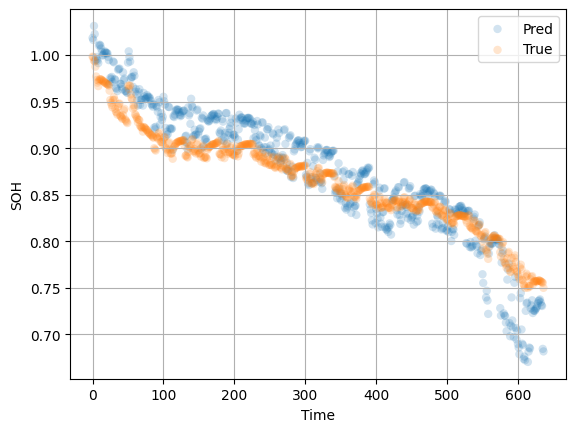

In [259]:
from drawings import drawDegradation
drawDegradation(target_loader_test=target_loader_test, model=f_g, regressor=regressor, device = device)

### TTA

In [254]:
from main_pretrains.main_tta import main_tta
from evaluator import evaluate

f_g = TransformerSOH(input_dim=1, embed_dim=128, num_heads=4, num_layers=2, PPA=True).to(device)
f_g.load_state_dict(torch.load("saved_models/transformer/f_g.pt"))
regressor = nn.Linear(f_g.input_linear.out_features, 1).to(device)
regressor.load_state_dict(torch.load("saved_models/transformer/regressor.pt"))

for name, param in f_g.named_parameters():
    if name =='soft_prompt':
        param.requires_grad = True
    else:
        param.requires_grad = True

# Print trainable and frozen parameters
print("Trainable parameters:")
trainable_params_count = 0
for name, param in f_g.named_parameters():
    if name =='soft_prompt':
        print('PPA params:', param.numel())
    if param.requires_grad:
        # print(name)
        trainable_params_count += param.numel()

print("\nFrozen parameters:")
frozen_params_count = 0
for name, param in f_g.named_parameters():
    if not param.requires_grad:
        # print(name)
        frozen_params_count += param.numel()

print(f"\nNumber of trainable parameters: {trainable_params_count}")
print(f"Total number of parameters: {trainable_params_count + frozen_params_count}")
print(f"Number of frozen parameters: {frozen_params_count}")



Trainable parameters:
PPA params: 1280

Frozen parameters:

Number of trainable parameters: 2506369
Total number of parameters: 2506369
Number of frozen parameters: 0


In [266]:
import tracemalloc
# optimizer = optim.SGD(f_g.parameters(), lr=1e-2)
optimizer = optim.SGD([f_g.soft_prompt], lr=50e-1)

set_seed(5)
mae, rmse = evaluate(model = f_g, model_name='transformer', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(Before TTA) MAE: {mae}, RMSE: {rmse}")
# tracemalloc.start()
main_tta(target_loader=target_loader_test, model=f_g, regressor=regressor, optimizer=optimizer, device=device, mask_ratio=0.9, num_epochs=5)
# current, peak = tracemalloc.get_traced_memory()
# tracemalloc.stop()
# print(f"Full parameter tuning memory usage: Current = {current / 10**6} MB; Peak = {peak / 10**6} MB")
mae, rmse = evaluate(model = f_g, model_name='transformer', regressor=regressor, target_loader=target_loader_test, device=device)
print(f"(After TTA) MAE: {mae}, RMSE: {rmse}")

(Before TTA) MAE: 0.02095804177224636, RMSE: 0.025978850200772285
Epoch [1/5], TTA Reconstruction Loss: 0.05300589615944773
Target Loader - MAE: 0.021151147782802582, RMSE: 0.02610933966934681
Epoch [2/5], TTA Reconstruction Loss: 0.05566324677783996
Target Loader - MAE: 0.021324070170521736, RMSE: 0.026230018585920334
Epoch [3/5], TTA Reconstruction Loss: 0.05437604204053059
Target Loader - MAE: 0.021478889510035515, RMSE: 0.026340514421463013
Epoch [4/5], TTA Reconstruction Loss: 0.05197620499529876
Target Loader - MAE: 0.02163168229162693, RMSE: 0.02645277790725231
Epoch [5/5], TTA Reconstruction Loss: 0.05414806510088965
Target Loader - MAE: 0.021784886717796326, RMSE: 0.026567058637738228
(After TTA) MAE: 0.021784886717796326, RMSE: 0.026567058637738228


(1419,)
(1419,)


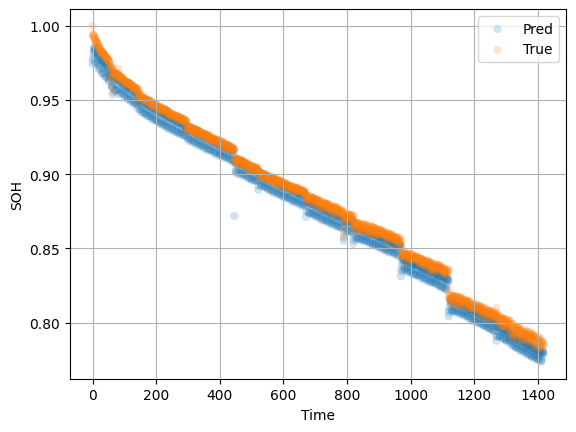

In [95]:
from drawings import drawDegradation
drawDegradation(target_loader_test=target_loader_test, model=f_g, regressor=regressor, device = device)